# 1 Apple store application rating prediction
https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps




By: Timon Borg, Joshua Latusia & Cézan von Meijenfeldt



All needed imports for the whole project can be found below

In [1]:
# place imports here
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


First we load in our dataset and look if the data is loaded correctly.

In [2]:
dataset = pd.read_csv('../dataset/AppleStore.csv')
dataset.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
# also look at the different types of the data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


Then we take a look if there are null values in our dataset and if this might have any consequences.

In [4]:
dataset.isnull().sum()

Unnamed: 0          0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

Since there are no null values, this shouldn't have any consequences for the rest of this project.

# 2 Data exploration

Now take a deeper look at the data

In [5]:
dataset.describe()

,Unnamed: 0,id,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
count,7197.000000,7.197000e+03,7.197000e+03,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,4759.069612,8.631310e+08,1.991345e+08,1.726218,1.289291e+04,460.373906,3.526956,3.253578,37.361817,3.707100,5.434903,0.993053
std,3093.625213,2.712368e+08,3.592069e+08,5.833006,7.573941e+04,3920.455183,1.517948,1.809363,3.737715,1.986005,7.919593,0.083066
min,1.000000,2.816565e+08,5.898240e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
25%,2090.000000,6.000937e+08,4.692275e+07,0.000000,2.800000e+01,1.000000,3.500000,2.500000,37.000000,3.000000,1.000000,1.000000
50%,4380.000000,9.781482e+08,9.715302e+07,0.000000,3.000000e+02,23.000000,4.000000,4.000000,37.000000,5.000000,1.000000,1.000000
75%,7223.000000,1.082310e+09,1.819249e+08,1.990000,2.793000e+03,140.000000,4.500000,4.500000,38.000000,5.000000,8.000000,1.000000
max,11097.000000,1.188376e+09,4.025970e+09,299.990000,2.974676e+06,177050.000000,5.000000,5.000000,47.000000,5.000000,75.000000,1.000000


Some things we notice here are:
1. More than 50% of apps are free and most apps are low prices even tough there are some high priced apps.
2. There will be both perfect rated apps and non rated apps in our model.
3. There are some columns that will 100% be not usefull during this project or are not clear what they mean (also after reading the documentation of the dataset. These Columns are the following: sup_devices.num, ipadSc_urls.num, lang.num, vpp_lic, track_name and Unnamed: 0. These colums will be removed at part 3 "Removeing noise data"

Now lets look if there are colums with some unique values like user rating etc.
This will be done using the pandas .unique() function

In [6]:
dataset.currency.unique()

array(['USD'], dtype=object)

Only one currency makes it so that we dont have to convert the prices to one and the same currency

In [7]:
dataset.user_rating.unique()

array([ 4. ,  3.5,  4.5,  5. ,  3. ,  2. ,  2.5,  0. ,  1.5,  1. ])

The rating of an app is between 0 and 5 with increments of 0.5 so there are no ratings like 3.66

In [8]:
dataset.prime_genre.unique()

array(['Games', 'Productivity', 'Weather', 'Shopping', 'Reference',
       'Finance', 'Music', 'Utilities', 'Travel', 'Social Networking',
       'Sports', 'Business', 'Health & Fitness', 'Entertainment',
       'Photo & Video', 'Navigation', 'Education', 'Lifestyle',
       'Food & Drink', 'News', 'Book', 'Medical', 'Catalogs'], dtype=object)

In [9]:
dataset.cont_rating.unique()

array(['4+', '12+', '17+', '9+'], dtype=object)

In [10]:
dataset.price.unique()

array([   3.99,    0.  ,    0.99,    9.99,    4.99,    7.99,    2.99,
          1.99,    5.99,   12.99,   21.99,  249.99,    6.99,   74.99,
         19.99,    8.99,   24.99,   13.99,   14.99,   16.99,   47.99,
         11.99,   59.99,   15.99,   27.99,   17.99,  299.99,   49.99,
         23.99,   20.99,   39.99,   99.99,   29.99,   34.99,   18.99,
         22.99])

# 3 Pre training data visualisation

After exploring some of the data we would also like to visualize some of the data. Visualization of the data might show some correlations which can help later to determine what is usefull for training our neural network.

The first thing we will visualize is the frequency of the different prices in the dataset with the help of a bar graph.

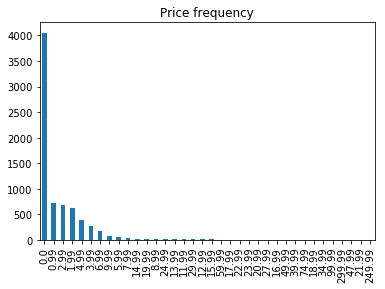

In [11]:
prices = dataset['price']
pd.value_counts(prices).plot.bar(title='Price frequency')

In this graph we can see that most ( 4000+ of the total 7200) apps are free.

The next thing we will visualize is the different genres the apps have

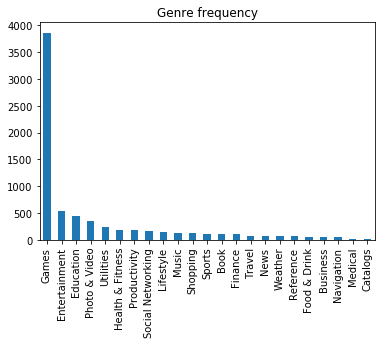

In [12]:
genres = dataset['prime_genre']
pd.value_counts(genres).plot.bar(title='Genre frequency')

In [13]:
len(dataset['prime_genre'])

7197

In this graph we can see that over 50% of the apps are games.

Next we look at the frequencies of the different rating of apps.

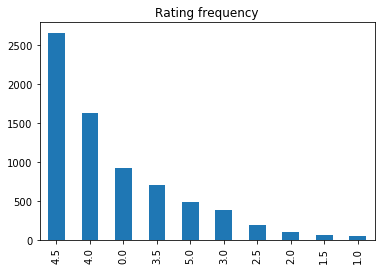

In [14]:
rating = dataset['user_rating']
pd.value_counts(rating).plot.bar(title='Rating frequency')

In this graph we can see that the gross of the apps have a 4 stars or higher rating. 
Next we can see there are a little less than a thousand apps with rating 0.0.
This means the app hasn't been rated yet, because the lowest rating an user can give is 1 star.
So later on we will remove the apps that haven't been rated yet because they wont help our neural network.

Last but not least we can see there are a little over 500 apps that have been rated with 5 stars. What we should keep in mind here is also the amount of ratings for this app because its pretty unlikely that an app recieves only 5 stars over a longer period of time.

Next we will take a look if there is any correlation between rating count and user rating.

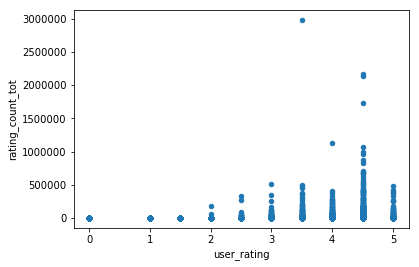

In [15]:
dataset.plot(kind='scatter', x='user_rating', y='rating_count_tot')

In this graph we can see that a higher user rating might also mean more rating count. 
This has to do with the popularity of the app. 
We also can see that apps with a 5.0 rating on average have less rating count then apps with 4.5 rating.
Still there are apps that have a 5.0 rating with a high rating count, 
this means the actual value of the user rating is being rounded up or down.

Finally we look at the content rating frequency, see graph below.

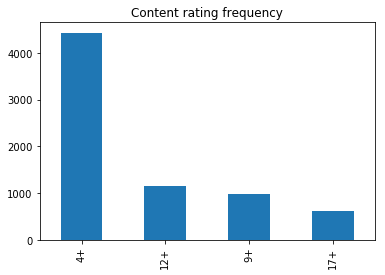

In [16]:
cont_rating = dataset['cont_rating']
pd.value_counts(cont_rating).plot.bar(title='Content rating frequency')

# 4 Removing noise data renaming and normalizing

In part 2 we found colums that will be dropped from the dataframe. These columns are: sup_devices.num, ipadSc_urls.num, lang.num, vpp_lic.
Also because there is 1 currency we don't need the currency column because the price column is enough.
After dropping we check if the actually are dropped by using the .head() function to look at the dataset

In [17]:
dataset = dataset.drop(["Unnamed: 0","track_name", "currency","sup_devices.num","ipadSc_urls.num","lang.num","vpp_lic","id"], axis=1)
dataset.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre
0,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games
1,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity
2,100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather
3,128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping
4,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference


After we drop the columns we also have to remove the rows where the app rating is 0.0.
To check if the removing succeeded we wil look at the bar graph of rating frequencies again.

In [18]:
# removing the rows where user rating is 0
dataset = dataset.drop(dataset[dataset.user_rating < 1].index)

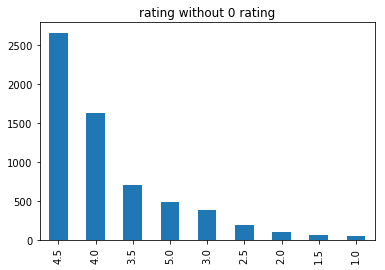

In [19]:
rating_without_0 = dataset['user_rating']
pd.value_counts(rating_without_0).plot.bar(title='rating without 0 rating')

In [20]:
# saving this dataset to our dataset folder so we can use this in the future.
dataset.to_csv("../dataset/AppleStoreWithoutNoise.csv", index=False, encoding='utf8')

Next thing we have to do is normalize some values and create catergories for non numeric values. 

As of now there are a lot of different app sizes which have a large spread. (obviously because its given in bytes) there are two options to normalize these. We can either: 
1. Put the different sizes into categories like : < 1mb or > 100mb etc.
2. Normalize the bytes to kb or even mb

Next there is the price, earlier we saw the prices range from 0 - 299.99. We have two options here:
1. Normalize by dividing by a own determined number.
2. use MinMax normalization which normalizes all numbers to be between 0 and 1
Option 2 should be the most optimal here for our model.

rating_count_tot has two options to normalize
1. Normalize by dividing by a own determined number.
2. use MinMax normalization which normalizes all numbers to be between 0 and 1
The best option here : TBA

rating_count_ver is not certain if this column can be used for our model so we will not normalize for now, but leave it in just in case.

user_rating is an easy scale that can be normalized using the MinMax normalization which is also the most optimal option for our model.

user_rating_ver is not certain if this column can be used for our model so we will not normalize for now, but leave it in just in case.

version is not certain if this column can be used for our model so we will not normalize for now, but leave it in just in case.

cont_rating and prime_genre both have multiple different possible values which are all text. To use these field we need to convert these someway to numbers. To do this we can us the function "get_dummies()" from pandas utils. This function will add the amount of unique values in columns to the dataset and mark the right feature value with a 1 and the rest with a 0.

In [21]:

datasetNew = dataset[dataset['rating_count_tot'] >= 100]  


In [22]:
dataset.describe()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver
count,6.268000e+03,6268.000000,6.268000e+03,6268.000000,6268.000000,6268.000000
mean,2.057430e+08,1.821977,1.480381e+04,528.607371,4.049697,3.735801
std,3.526341e+08,6.128238,8.098468e+04,4196.699812,0.726943,1.399040
min,5.898240e+05,0.000000,1.000000e+00,0.000000,1.000000,0.000000
25%,5.171942e+07,0.000000,7.800000e+01,6.000000,4.000000,3.500000
50%,1.021292e+08,0.000000,5.125000e+02,37.000000,4.500000,4.500000
75%,1.884774e+08,2.990000,3.963500e+03,176.000000,4.500000,4.500000
max,4.025970e+09,299.990000,2.974676e+06,177050.000000,5.000000,5.000000


In [23]:
# size_bytes normalization
# after looking at the data we can see the range is between 576kb and 3.72529Gb. 
# So the first thing we can do is convert the size_bytes to size_100kilo_bytes by dividing 1024 (b -> kb) and 100 (kb ->100kb)

datasetNew['size_100kilo_bytes'] = datasetNew['size_bytes']/102400

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [24]:
datasetNew.describe()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,size_100kilo_bytes
count,4.497000e+03,4497.000000,4.497000e+03,4497.000000,4497.000000,4497.000000,4497.000000
mean,2.052734e+08,1.639455,2.061976e+04,731.499222,4.150100,3.982877,2004.622601
std,3.598327e+08,5.095840,9.498534e+04,4940.038743,0.596957,1.113018,3513.991230
min,7.671260e+05,0.000000,1.000000e+02,0.000000,1.000000,0.000000,7.491465
25%,5.567898e+07,0.000000,3.910000e+02,18.000000,4.000000,4.000000,543.740000
50%,1.060004e+08,0.000000,1.560000e+03,88.000000,4.500000,4.500000,1035.160000
75%,1.859144e+08,1.990000,8.249000e+03,316.000000,4.500000,4.500000,1815.570000
max,4.025970e+09,249.990000,2.974676e+06,177050.000000,5.000000,5.000000,39316.110000


In [25]:
# price normalization

mms = MinMaxScaler()
datasetNew['price_mms'] = mms.fit_transform(datasetNew[['price']])

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
# rating_count_tot normalization
datasetNew['rating_count_mms'] = mms.fit_transform(datasetNew[['rating_count_tot']])

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
# user_rating normalization

datasetNew['user_rating_mms'] = mms.fit_transform(datasetNew[['user_rating']])

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# user_rating size_bytes

datasetNew['size_bytes_mms'] = mms.fit_transform(datasetNew[['size_bytes']])

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# cont_rating and prime_genre dummies

dataset_dummies = pd.get_dummies(datasetNew[['cont_rating','prime_genre']])
dataset_dummies.head()

,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,prime_genre_Book,prime_genre_Business,prime_genre_Catalogs,prime_genre_Education,prime_genre_Entertainment,prime_genre_Finance,...,prime_genre_News,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
# Check if all values are now normalized correct
datasetNew.describe()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,size_100kilo_bytes,price_mms,rating_count_mms,user_rating_mms,size_bytes_mms
count,4.497000e+03,4497.000000,4.497000e+03,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000
mean,2.052734e+08,1.639455,2.061976e+04,731.499222,4.150100,3.982877,2004.622601,0.006558,0.006898,0.787525,0.050806
std,3.598327e+08,5.095840,9.498534e+04,4940.038743,0.596957,1.113018,3513.991230,0.020384,0.031932,0.149239,0.089395
min,7.671260e+05,0.000000,1.000000e+02,0.000000,1.000000,0.000000,7.491465,0.000000,0.000000,0.000000,0.000000
25%,5.567898e+07,0.000000,3.910000e+02,18.000000,4.000000,4.000000,543.740000,0.000000,0.000098,0.750000,0.013642
50%,1.060004e+08,0.000000,1.560000e+03,88.000000,4.500000,4.500000,1035.160000,0.000000,0.000491,0.875000,0.026144
75%,1.859144e+08,1.990000,8.249000e+03,316.000000,4.500000,4.500000,1815.570000,0.007960,0.002740,0.875000,0.045997
max,4.025970e+09,249.990000,2.974676e+06,177050.000000,5.000000,5.000000,39316.110000,1.000000,1.000000,1.000000,1.000000


In [31]:
# saving this dataset to our dataset folder so we can use this in the future.
datasetNew.to_csv("../dataset/AppleStoreNormalized.csv", index=False, encoding='utf8')


# Setting up and training a model

Cleanup app prices to clean the data

In [32]:
datasetNew['is_not_free'] = datasetNew['price'].apply(lambda x: 1 if x > 0 else 0)
datasetNew.head()

C:\Users\cezan\AppData\Local\conda\conda\envs\MLA\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,size_100kilo_bytes,price_mms,rating_count_mms,user_rating_mms,size_bytes_mms,is_not_free
0,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,984.26,0.015961,0.007124,0.750,0.024849,1
1,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,1548.62,0.000000,0.054114,0.750,0.039206,0
2,100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,981.68,0.000000,0.063365,0.625,0.024783,0
3,128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,1255.00,0.000000,0.088127,0.750,0.031736,0
4,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,906.00,0.000000,0.331415,0.875,0.022858,0


Used to categorize ratings. Everyhting above 4 gets a 1 everything else a 0 

In [33]:
def categorize_rating(x):
    if x < 4.5:
        return 0
    else:
        return 1

Create X & Y lists for training. 
Create X_train X_test Y_train Y_test with 0.2 train test split

In [34]:
X = pd.concat([datasetNew[['is_not_free', 'rating_count_mms', 'size_bytes_mms']], dataset_dummies], axis=1).values
Y = datasetNew['user_rating']
y = dataset['user_rating']
Y = Y.apply(categorize_rating).values
y = y.apply(categorize_rating).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
len(X_train)
X.shape

(4497, 30)

# Benchmark

Calculate the benchmark off the liked dataset lowest possible ACC

In [35]:
print(sum(y) / float(len(y)))

0.503350350989


Function to create the ML model it is a categorical ML model using the sigmoid activation function.
The loss is calculated with a binary_crossentropy



In [49]:
def model_builder_sigmoid():
    model = Sequential()
    model.add(Dense(15, input_shape=(30,), activation='relu'))
    model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(SGD(lr=0.75), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    #model.fit(X_train, Y_train, epochs=25)
    return model

Kfold training and accuracy of the model

In [50]:
model = KerasClassifier(build_fn=model_builder_sigmoid,
                        epochs=25,
                        verbose=0)
cv = KFold(3, shuffle=True)
scores = cross_val_score(model, X, Y, cv=cv)
print("The cross validation accuracy is {:0.4f} ± {:0.4f}".format(scores.mean(), scores.std()))

The cross validation accuracy is 0.6155 ± 0.0088


Normal training with split train and test data

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix


model = model_builder_sigmoid()
print("training model please wait...")
model.fit(X_train, Y_train, epochs=50, verbose=0)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("The Accuracy score on the Train set is:\t{:0.3f}".format(accuracy_score(Y_train, y_train_pred.round())))
print("The Accuracy score on the Test set is:\t{:0.3f}".format(accuracy_score(Y_test, y_test_pred.round())))

training model please wait...
The Accuracy score on the Train set is:	0.645
The Accuracy score on the Test set is:	0.616


# Conclusie
Uit de getrainde data is gebleken dat er een verband is tussen de gekozen features/dataset omdat tijdens het trainen de ACC weldegelijk omhoog gaat de loss naar beneden. Ook is gebleken dat de ACC van ons netwerk hoger ligt dan onze benchmark, dit betekent dat ons netwerk het beter doet dan willekeurig gokken. Uitendelijk is onze ACC nog niet op het niveau waar wij hem graag zouden zien, maar dit kan mogelijk komen doordat er geen duidelijk genoeg verband is tussen de features in de data set de de rating. Om een betere uitspraak te kunnen doen hebben we features nodig zoals speeltijd of hoevaak de app is geopend & gedownload. Hieruit zou je een beter geronde uitspraak kunnen doen dan baseren op features zoals categorie & prijs. 

# Old not working code
Deze code probeerd de exacte rating van de appte voorspellen dit is telastig gebleken en wordt niet meer gebruikt. 


dont run this!

In [ ]:
#model = Sequential()
#model.add(Dense(29, input_dim=29, kernel_initializer='normal', activation='relu'))
#model.add(Dense(14, kernel_initializer='normal', activation='relu'))
#model.add(Dense(1, kernel_initializer='normal'))
#model.compile(Adam(lr=0.05), 'mean_squared_error')

# define the model
def model_builder():
# create model
	model = Sequential()
	model.add(Dense(1, input_dim=29, kernel_initializer='normal', activation='relu'))
#model.add(Dense(6, kernel_initializer='normal', activation='relu'))
#model.add(Dense(1, kernel_initializer='normal'))
# Compile model
	model.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=['accuracy'])
	return model



In [ ]:
X = pd.concat([copy[['price_mms', 'rating_count_mms']], dataset_dummies], axis=1).values
X.shape
Y = dataset['user_rating_mms'].values
Y.shape
Y

In [ ]:
seed =7
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=model_builder, epochs=50, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))



#model.fit(X_train, y_train, epochs=400)

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=29, kernel_initializer='normal', activation='relu'))##
#model.add(Dense(6, kernel_initializer='normal', activation='relu'))
#model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=50, verbose=1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

y_train_pred = model.predict(X_train).ravel()
y_test_pred = model.predict(X_test).ravel()

print("The Mean Squared Error on the Train set is:\t{:0.1f}".format(mse(Y_train, y_train_pred)))
print("The Mean Squared Error on the Test set is:\t{:0.1f}".format(mse(Y_test, y_test_pred)))
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, y_test_pred)))

In [ ]:
model = KerasClassifier(build_fn=model_builder,
                        epochs=50,
                        verbose=1)
cv = KFold(5, shuffle=True)
scores = cross_val_score(model, X, Y, cv=cv)
print("The cross validation accuracy is {:0.4f} ± {:0.4f}".format(scores.mean(), scores.std()))